In [1]:
from algorithm import (
                        NoRegularizationTrainer,
                        GradientTrainer,
                        EGTrainer,
                        CSVDataLoader,
                        MultiTaskModel,
                        MultiTaskDataset,
                        mlt_train_test_split,
                        # true_values_from_data_loader,
                        unique_value_counts,
                        Cindex,
                        brier_score,
                        )
import easydict
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np

Based on your feedback regarding the c-index value, I have thoroughly investigated the model, dataset, and other evaluation metrics. Here are my findings:

Initially, I replaced the random data splitting method with a stratified approach based on events. This revealed an imbalance in the data across different time intervals. Since we are grouping times into seven buckets, the data counts for each bucket are as follow.

As you can see, the initial buckets dominate (Which is common in survival data), which suggests that the model will struggle with learning from the later buckets. 

Additionally, I implemented a learning rate scheduler, early stopping, and best model checkpointing based on the best validation loss. With these setups, I trained the model under three conditions: without any attribution regularization term, with expected gradient as the attribution method, and with only gradient as the attribution method. I calculated C-Index and Integrated Brier Score for these three models.



In [2]:
def plot_unique_values_count(unique_values, counts, title):
    plt.figure(figsize=(10, 6))
    plt.bar(unique_values, counts, tick_label=unique_values)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

Unique Values: tensor([0., 1., 2., 3., 4., 5., 6., 7.])
Counts: tensor([4114, 4060, 1622, 2116, 1631,  893,  256,   63])


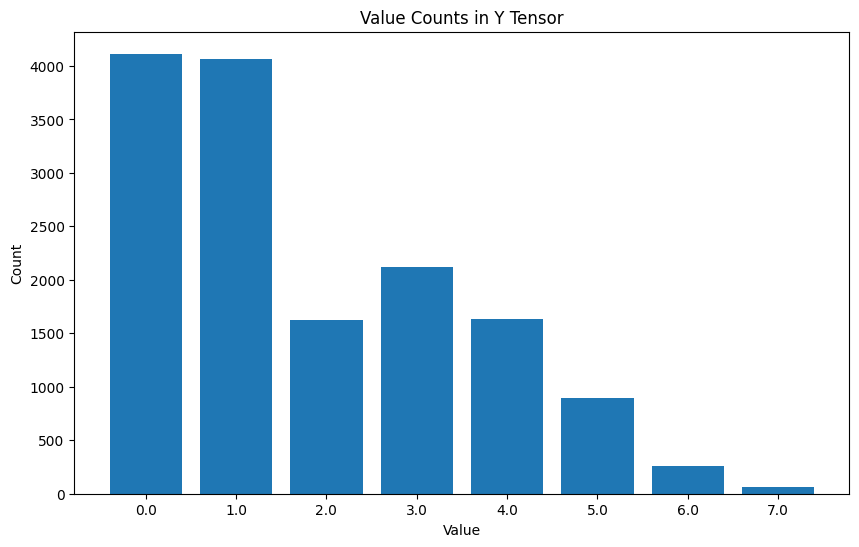

In [3]:
dl = CSVDataLoader()
X, Y, Y_transform, W, W_transform, time_all, event_all = dl.get_data(num_intervals=7)


unique_values, counts = unique_value_counts(Y.sum(axis=1))
plot_unique_values_count(unique_values, counts, 'Value Counts in Y Tensor')

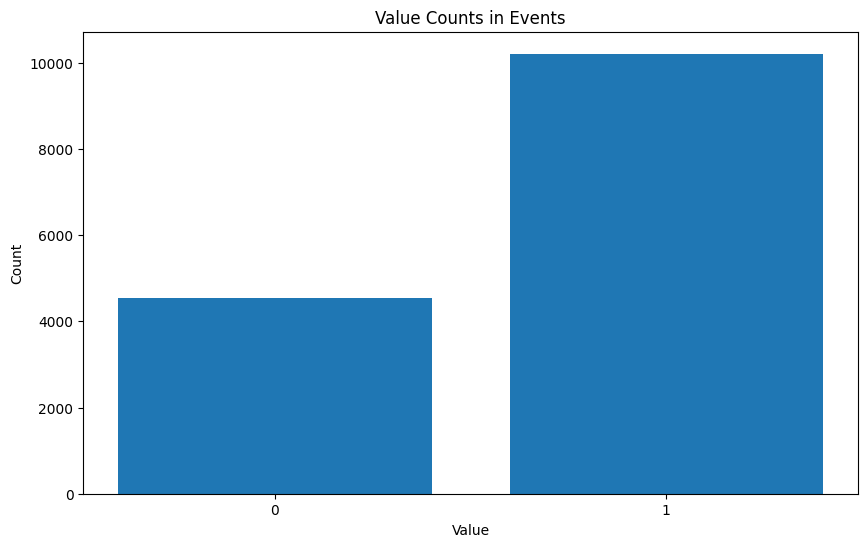

In [4]:

unique_values, counts = np.unique(event_all, return_counts=True)
plot_unique_values_count(unique_values, counts, 'Value Counts in Events')

Since the model without any regularization term yields almost the same c-index value, and considering that, based on your initial instructions, the data preprocessing and evaluation metrics implementations are correct, I believe there is no problem with the training process.

I suggest to use cross validation for better estimation of these mehods.

# Training model with no Regularization

In [10]:
dl = CSVDataLoader()
X, Y, Y_transform, W, W_transform, time_all, event_all = dl.get_data(num_intervals=7)

args = easydict.EasyDict({
    "batch_size": 64,
    "lr": 0.01,
    "epochs": 200,
    "clip": 5.0,
    "lambda_reg": 0.01,
    "save_path": "outputfiles",
    "eg_k" : 5, 
    "early_stop_patience":15,
})


full_dataset = MultiTaskDataset(X, Y_transform, W_transform, event_all)

train_loader, test_loader, train_dataset, test_dataset , in_features, out_features = (
    mlt_train_test_split(full_dataset, range(len(X)), event_all, args.batch_size, ratio=0.25))


model = MultiTaskModel(in_features, out_features)


no_reg_trainer = NoRegularizationTrainer(model,train_loader,test_loader,args)
no_reg_trainer.train()



  0%|          | 1/200 [00:01<05:10,  1.56s/it]

End of Epoch 0, Average Training Loss: 1.5235, Average Gradient Norm: 1.7815
End of Epoch 0, Average Validation Loss: 1.2065
Current Learning Rate: 0.010000


  1%|          | 2/200 [00:02<04:50,  1.47s/it]

End of Epoch 1, Average Training Loss: 1.1061, Average Gradient Norm: 1.7674
End of Epoch 1, Average Validation Loss: 1.0537
Current Learning Rate: 0.010000


  1%|          | 2/200 [00:04<06:59,  2.12s/it]

End of Epoch 2, Average Training Loss: 1.0578, Average Gradient Norm: 1.7513


KeyboardInterrupt: 

## Evaluating model with no regularization

In [6]:
no_reg_trainer.load_best_checkpoint()

print("Evaluation On Train Data \n")

predictions, Y_hat, Y_true, events = no_reg_trainer.predict(train_loader)
print("Y_true Train")
unique_value_counts(Y_true)
print("Y_hat Train")
unique_value_counts(Y_hat)

cindex_calculator = Cindex()
cindex_test = cindex_calculator(Y_true, Y_hat, events)
bscore_test = brier_score(event_all, Y, events, Y_true, predictions)
print(f"Train Data C-Index = {cindex_test},  BScore = {bscore_test}")



print("\nEvaluation On Test Data \n")

predictions, Y_hat, Y_true, events = no_reg_trainer.predict(test_loader)
print("Y_true Test")
unique_value_counts(Y_true)
print("Y_hat Test")
unique_value_counts(Y_hat)

cindex_calculator = Cindex()
cindex_test = cindex_calculator(Y_true, Y_hat, events)
bscore_test = brier_score(event_all, Y, events, Y_true, predictions)
print(f"Test Data C-Index = {cindex_test},  BScore = {bscore_test}")
# print(classification_report(Y_true_test.cpu(), Y_hat_test.cpu()))

Loaded model from checkpoint at epoch 13 with best validation loss 1.0396
Evaluation On Train Data 
Y_true Train
Unique Values: tensor([0., 1., 2., 3., 4., 5., 6., 7.], dtype=torch.float64)
Counts: tensor([3057, 3025, 1208, 1593, 1215,  675,  191,   44])
Y_hat Train
Unique Values: tensor([0, 1, 2, 3, 4, 5, 6, 7], dtype=torch.int32)
Counts: tensor([2646, 2475, 1451,  792,  398,   12,    8, 3226])


100%|██████████| 11008/11008 [00:01<00:00, 8061.59it/s]


Train Data C-Index = 0.982032060623169,  BScore = 0.06191517515654854

Evaluation On Test Data 

Y_true Test
Unique Values: tensor([0., 1., 2., 3., 4., 5., 6., 7.], dtype=torch.float64)
Counts: tensor([1026, 1009,  404,  507,  406,  214,   64,   18])
Y_hat Test
Unique Values: tensor([0, 1, 2, 3, 4, 5, 6, 7], dtype=torch.int32)
Counts: tensor([ 884,  775,  496,  288,  120,    1,    9, 1075])


100%|██████████| 3648/3648 [00:00<00:00, 8142.86it/s]


Test Data C-Index = 0.9798187613487244,  BScore = 0.06714734390115036


# Training model with Expected Gradient

In [11]:
dl = CSVDataLoader()
X, Y, Y_transform, W, W_transform, time_all, event_all = dl.get_data()

args = easydict.EasyDict({
    "batch_size": 64,
    "lr": 0.01,
    "epochs": 200,
    "clip": 5.0,
    "lambda_reg": 0.01,
    "save_path": "outputfiles",
    "eg_k" : 1, 
    "early_stop_patience":15,
})


full_dataset = MultiTaskDataset(X, Y_transform, W_transform, event_all)

train_loader, test_loader, train_dataset, test_dataset , in_features, out_features = (
    mlt_train_test_split(full_dataset, range(len(X)), event_all, args.batch_size, ratio=0.25))


model = MultiTaskModel(in_features, out_features)


eg_trainer = EGTrainer(model, train_loader, test_loader, train_dataset, args)
eg_trainer.train()





  0%|          | 1/200 [00:03<11:52,  3.58s/it]

End of Epoch 0, Average Training Loss: 2.0793, Average Gradient Norm: 2.5265
End of Epoch 0, Average Validation Loss: 1.3944
Current Learning Rate: 0.010000


  1%|          | 2/200 [00:06<11:22,  3.45s/it]

End of Epoch 1, Average Training Loss: 1.7410, Average Gradient Norm: 3.5786
End of Epoch 1, Average Validation Loss: 1.2652
Current Learning Rate: 0.010000


  2%|▏         | 3/200 [00:10<11:08,  3.39s/it]

End of Epoch 2, Average Training Loss: 1.6960, Average Gradient Norm: 3.6496
End of Epoch 2, Average Validation Loss: 1.1809
Current Learning Rate: 0.010000


  2%|▏         | 4/200 [00:13<11:08,  3.41s/it]

End of Epoch 3, Average Training Loss: 1.6655, Average Gradient Norm: 3.6882
End of Epoch 3, Average Validation Loss: 1.1306
Current Learning Rate: 0.010000


  2%|▎         | 5/200 [00:17<11:05,  3.41s/it]

End of Epoch 4, Average Training Loss: 1.6650, Average Gradient Norm: 3.7638
End of Epoch 4, Average Validation Loss: 1.4148
Current Learning Rate: 0.010000


  3%|▎         | 6/200 [00:20<10:50,  3.35s/it]

End of Epoch 5, Average Training Loss: 1.6515, Average Gradient Norm: 4.1144
End of Epoch 5, Average Validation Loss: 1.4252
Current Learning Rate: 0.010000


  4%|▎         | 7/200 [00:23<10:46,  3.35s/it]

End of Epoch 6, Average Training Loss: 1.6818, Average Gradient Norm: 4.0609
End of Epoch 6, Average Validation Loss: 1.1199
Current Learning Rate: 0.010000


  4%|▍         | 8/200 [00:26<10:37,  3.32s/it]

End of Epoch 7, Average Training Loss: 1.6474, Average Gradient Norm: 4.0987
End of Epoch 7, Average Validation Loss: 1.3999
Current Learning Rate: 0.010000


  4%|▍         | 9/200 [00:30<10:24,  3.27s/it]

End of Epoch 8, Average Training Loss: 1.6381, Average Gradient Norm: 4.3265
End of Epoch 8, Average Validation Loss: 1.2568
Current Learning Rate: 0.010000
End of Epoch 9, Average Training Loss: 1.6313, Average Gradient Norm: 4.0854


  5%|▌         | 10/200 [00:33<10:18,  3.25s/it]

End of Epoch 9, Average Validation Loss: 1.4031
Current Learning Rate: 0.010000


  6%|▌         | 11/200 [00:36<10:08,  3.22s/it]

End of Epoch 10, Average Training Loss: 1.6554, Average Gradient Norm: 4.3319
End of Epoch 10, Average Validation Loss: 1.2485
Current Learning Rate: 0.010000
End of Epoch 11, Average Training Loss: 1.6111, Average Gradient Norm: 4.5753
End of Epoch 11, Average Validation Loss: 1.3078
Current Learning Rate: 0.010000


  6%|▋         | 13/200 [00:43<10:07,  3.25s/it]

End of Epoch 12, Average Training Loss: 1.7026, Average Gradient Norm: 5.1811
End of Epoch 12, Average Validation Loss: 1.4090
Current Learning Rate: 0.001000


  7%|▋         | 14/200 [00:46<10:10,  3.28s/it]

End of Epoch 13, Average Training Loss: 1.5356, Average Gradient Norm: 3.4420
End of Epoch 13, Average Validation Loss: 1.1233
Current Learning Rate: 0.001000
End of Epoch 14, Average Training Loss: 1.4955, Average Gradient Norm: 4.2402


  8%|▊         | 15/200 [00:52<13:01,  4.23s/it]

End of Epoch 14, Average Validation Loss: 1.1278
Current Learning Rate: 0.001000
End of Epoch 15, Average Training Loss: 1.4858, Average Gradient Norm: 4.5345


  8%|▊         | 16/200 [00:59<15:29,  5.05s/it]

End of Epoch 15, Average Validation Loss: 1.1453
Current Learning Rate: 0.001000
End of Epoch 16, Average Training Loss: 1.4734, Average Gradient Norm: 4.7792


  8%|▊         | 17/200 [01:06<17:10,  5.63s/it]

End of Epoch 16, Average Validation Loss: 1.0924
Current Learning Rate: 0.001000
End of Epoch 17, Average Training Loss: 1.4792, Average Gradient Norm: 5.0956


  9%|▉         | 18/200 [01:13<18:10,  5.99s/it]

End of Epoch 17, Average Validation Loss: 1.0926
Current Learning Rate: 0.001000
End of Epoch 18, Average Training Loss: 1.4800, Average Gradient Norm: 5.0442


 10%|▉         | 19/200 [01:20<18:48,  6.23s/it]

End of Epoch 18, Average Validation Loss: 1.1251
Current Learning Rate: 0.001000
End of Epoch 19, Average Training Loss: 1.4839, Average Gradient Norm: 5.1679


 10%|█         | 20/200 [01:27<19:24,  6.47s/it]

End of Epoch 19, Average Validation Loss: 1.0784
Current Learning Rate: 0.001000
End of Epoch 20, Average Training Loss: 1.4482, Average Gradient Norm: 5.5706


 10%|█         | 21/200 [01:34<19:33,  6.56s/it]

End of Epoch 20, Average Validation Loss: 1.0931
Current Learning Rate: 0.001000


 11%|█         | 22/200 [01:37<16:24,  5.53s/it]

End of Epoch 21, Average Training Loss: 1.4718, Average Gradient Norm: 5.9844
End of Epoch 21, Average Validation Loss: 1.1115
Current Learning Rate: 0.001000


 12%|█▏        | 23/200 [01:40<14:15,  4.83s/it]

End of Epoch 22, Average Training Loss: 1.4632, Average Gradient Norm: 5.9483
End of Epoch 22, Average Validation Loss: 1.1776
Current Learning Rate: 0.001000


 12%|█▏        | 24/200 [01:43<12:45,  4.35s/it]

End of Epoch 23, Average Training Loss: 1.4751, Average Gradient Norm: 6.3951
End of Epoch 23, Average Validation Loss: 1.0889
Current Learning Rate: 0.001000
End of Epoch 24, Average Training Loss: 1.4682, Average Gradient Norm: 6.0106


 12%|█▎        | 25/200 [01:50<14:23,  4.93s/it]

End of Epoch 24, Average Validation Loss: 1.0936
Current Learning Rate: 0.001000


 13%|█▎        | 26/200 [01:56<15:32,  5.36s/it]

End of Epoch 25, Average Training Loss: 1.4587, Average Gradient Norm: 6.0276
End of Epoch 25, Average Validation Loss: 1.1000
Current Learning Rate: 0.000100


 14%|█▎        | 27/200 [01:59<13:42,  4.76s/it]

End of Epoch 26, Average Training Loss: 1.4485, Average Gradient Norm: 5.9077
End of Epoch 26, Average Validation Loss: 1.0942
Current Learning Rate: 0.000100


 14%|█▍        | 28/200 [02:03<12:25,  4.34s/it]

End of Epoch 27, Average Training Loss: 1.4117, Average Gradient Norm: 5.8643
End of Epoch 27, Average Validation Loss: 1.0968
Current Learning Rate: 0.000100
End of Epoch 28, Average Training Loss: 1.4334, Average Gradient Norm: 6.1669


 14%|█▍        | 29/200 [02:07<12:22,  4.34s/it]

End of Epoch 28, Average Validation Loss: 1.0944
Current Learning Rate: 0.000100


 15%|█▌        | 30/200 [02:12<13:09,  4.64s/it]

End of Epoch 29, Average Training Loss: 1.4292, Average Gradient Norm: 5.9661
End of Epoch 29, Average Validation Loss: 1.0964
Current Learning Rate: 0.000100
End of Epoch 30, Average Training Loss: 1.4193, Average Gradient Norm: 6.1863


 16%|█▌        | 31/200 [02:16<12:10,  4.32s/it]

End of Epoch 30, Average Validation Loss: 1.0979
Current Learning Rate: 0.000100


 16%|█▌        | 32/200 [02:20<11:29,  4.11s/it]

End of Epoch 31, Average Training Loss: 1.4218, Average Gradient Norm: 6.2419
End of Epoch 31, Average Validation Loss: 1.0828
Current Learning Rate: 0.000010


 16%|█▋        | 33/200 [02:23<10:51,  3.90s/it]

End of Epoch 32, Average Training Loss: 1.4419, Average Gradient Norm: 6.0877
End of Epoch 32, Average Validation Loss: 1.0869
Current Learning Rate: 0.000010


 17%|█▋        | 34/200 [02:27<10:32,  3.81s/it]

End of Epoch 33, Average Training Loss: 1.4277, Average Gradient Norm: 5.9502
End of Epoch 33, Average Validation Loss: 1.0896
Current Learning Rate: 0.000010
End of Epoch 34, Average Training Loss: 1.4209, Average Gradient Norm: 6.0136


 17%|█▋        | 34/200 [02:30<12:14,  4.43s/it]

End of Epoch 34, Average Validation Loss: 1.0924
Current Learning Rate: 0.000010
Early stopping triggered after 35 epochs.


## Evaluating model with expected gradient

In [12]:
eg_trainer.load_best_checkpoint()

print("Evaluation On Train Data \n")

predictions, Y_hat, Y_true, events = eg_trainer.predict(train_loader)
print("Y_true Train")
unique_value_counts(Y_true)
print("Y_hat Train")
unique_value_counts(Y_hat)

cindex_calculator = Cindex()
cindex_test = cindex_calculator(Y_true, Y_hat, events)
bscore_test = brier_score(event_all, Y, events, Y_true, predictions)
print(f"Train Data C-Index = {cindex_test},  BScore = {bscore_test}")



print("\nEvaluation On Test Data \n")

predictions, Y_hat, Y_true, events = eg_trainer.predict(test_loader)
print("Y_true Test")
unique_value_counts(Y_true)
print("Y_hat Test")
unique_value_counts(Y_hat)

cindex_calculator = Cindex()
cindex_test = cindex_calculator(Y_true, Y_hat, events)
bscore_test = brier_score(event_all, Y, events, Y_true, predictions)
print(f"Test Data C-Index = {cindex_test},  BScore = {bscore_test}")

Loaded model from checkpoint at epoch 20 with best validation loss 1.0784
Evaluation On Train Data 
Y_true Train
Unique Values: tensor([0., 1., 2., 3., 4., 5., 6., 7.], dtype=torch.float64)
Counts: tensor([3051, 3021, 1212, 1599, 1217,  674,  190,   44])
Y_hat Train
Unique Values: tensor([0, 1, 2, 3, 4, 7], dtype=torch.int32)
Counts: tensor([2735, 2957,  861,  721,  355, 3379])


100%|██████████| 11008/11008 [00:01<00:00, 7213.39it/s]


Train Data C-Index = 0.9753935933113098,  BScore = 0.06693808592112391

Evaluation On Test Data 

Y_true Test
Unique Values: tensor([0., 1., 2., 3., 4., 5., 6., 7.], dtype=torch.float64)
Counts: tensor([1026, 1009,  404,  507,  406,  214,   64,   18])
Y_hat Test
Unique Values: tensor([0, 1, 2, 3, 4, 7], dtype=torch.int32)
Counts: tensor([ 918,  966,  297,  222,  125, 1120])


100%|██████████| 3648/3648 [00:00<00:00, 8017.09it/s]

Test Data C-Index = 0.9744025468826294,  BScore = 0.06894147858088405


# Training model with gradient attribution

In [13]:
dl = CSVDataLoader()
X, Y, Y_transform, W, W_transform, time_all, event_all = dl.get_data()

args = easydict.EasyDict({
    "batch_size": 64,
    "lr": 0.01,
    "epochs": 200,
    "clip": 5.0,
    "lambda_reg": 0.01,
    "save_path": "outputfiles",
    "eg_k" : 5, 
    "early_stop_patience":15,
})


full_dataset = MultiTaskDataset(X, Y_transform, W_transform, event_all)

train_loader, test_loader, train_dataset, test_dataset , in_features, out_features = (
    mlt_train_test_split(full_dataset, range(len(X)), event_all, args.batch_size, ratio=0.25))


model = MultiTaskModel(in_features, out_features)


g_trainer = GradientTrainer(model, train_loader, test_loader, args)
g_trainer.train()





  0%|          | 1/200 [00:02<08:55,  2.69s/it]

End of Epoch 0, Average Training Loss: 2.3730, Average Gradient Norm: 5.1345
End of Epoch 0, Average Validation Loss: 1.8684
Current Learning Rate: 0.010000
End of Epoch 1, Average Training Loss: 2.0289, Average Gradient Norm: 6.8747
End of Epoch 1, Average Validation Loss: 1.9101
Current Learning Rate: 0.010000


  2%|▏         | 3/200 [00:07<08:29,  2.59s/it]

End of Epoch 2, Average Training Loss: 1.9696, Average Gradient Norm: 7.7292
End of Epoch 2, Average Validation Loss: 1.8523
Current Learning Rate: 0.010000


  2%|▏         | 4/200 [00:10<08:19,  2.55s/it]

End of Epoch 3, Average Training Loss: 1.9513, Average Gradient Norm: 8.1893
End of Epoch 3, Average Validation Loss: 1.8048
Current Learning Rate: 0.010000


  2%|▎         | 5/200 [00:12<08:09,  2.51s/it]

End of Epoch 4, Average Training Loss: 1.9305, Average Gradient Norm: 8.8037
End of Epoch 4, Average Validation Loss: 1.7990
Current Learning Rate: 0.010000


  3%|▎         | 6/200 [00:15<08:14,  2.55s/it]

End of Epoch 5, Average Training Loss: 1.9189, Average Gradient Norm: 9.5772
End of Epoch 5, Average Validation Loss: 1.8027
Current Learning Rate: 0.010000


  4%|▎         | 7/200 [00:17<08:00,  2.49s/it]

End of Epoch 6, Average Training Loss: 1.9184, Average Gradient Norm: 9.3477
End of Epoch 6, Average Validation Loss: 1.8720
Current Learning Rate: 0.010000


  4%|▍         | 8/200 [00:20<08:08,  2.54s/it]

End of Epoch 7, Average Training Loss: 1.9079, Average Gradient Norm: 9.8652
End of Epoch 7, Average Validation Loss: 1.8324
Current Learning Rate: 0.010000


  4%|▍         | 9/200 [00:22<07:59,  2.51s/it]

End of Epoch 8, Average Training Loss: 1.9285, Average Gradient Norm: 10.0026
End of Epoch 8, Average Validation Loss: 1.8354
Current Learning Rate: 0.010000


  5%|▌         | 10/200 [00:25<07:56,  2.51s/it]

End of Epoch 9, Average Training Loss: 1.9396, Average Gradient Norm: 9.1023
End of Epoch 9, Average Validation Loss: 1.8197
Current Learning Rate: 0.010000
End of Epoch 10, Average Training Loss: 1.9323, Average Gradient Norm: 9.7771


  6%|▌         | 11/200 [00:27<07:54,  2.51s/it]

End of Epoch 10, Average Validation Loss: 1.8249
Current Learning Rate: 0.001000


  6%|▌         | 12/200 [00:30<07:49,  2.50s/it]

End of Epoch 11, Average Training Loss: 1.8061, Average Gradient Norm: 10.4674
End of Epoch 11, Average Validation Loss: 1.7959
Current Learning Rate: 0.001000
End of Epoch 12, Average Training Loss: 1.7883, Average Gradient Norm: 13.2200


  6%|▋         | 13/200 [00:32<07:50,  2.52s/it]

End of Epoch 12, Average Validation Loss: 1.7887
Current Learning Rate: 0.001000


  7%|▋         | 14/200 [00:35<07:39,  2.47s/it]

End of Epoch 13, Average Training Loss: 1.7808, Average Gradient Norm: 14.7023
End of Epoch 13, Average Validation Loss: 1.7790
Current Learning Rate: 0.001000
End of Epoch 14, Average Training Loss: 1.7799, Average Gradient Norm: 15.4716


  8%|▊         | 15/200 [00:39<09:32,  3.09s/it]

End of Epoch 14, Average Validation Loss: 1.7803
Current Learning Rate: 0.001000
End of Epoch 15, Average Training Loss: 1.7713, Average Gradient Norm: 16.5986


  8%|▊         | 16/200 [00:45<11:30,  3.75s/it]

End of Epoch 15, Average Validation Loss: 1.7755
Current Learning Rate: 0.001000
End of Epoch 16, Average Training Loss: 1.7681, Average Gradient Norm: 17.0786


  8%|▊         | 17/200 [00:50<12:51,  4.22s/it]

End of Epoch 16, Average Validation Loss: 1.7853
Current Learning Rate: 0.001000
End of Epoch 17, Average Training Loss: 1.7713, Average Gradient Norm: 18.1587


  9%|▉         | 18/200 [00:55<13:44,  4.53s/it]

End of Epoch 17, Average Validation Loss: 1.7697
Current Learning Rate: 0.001000
End of Epoch 18, Average Training Loss: 1.7638, Average Gradient Norm: 18.5826


 10%|▉         | 19/200 [01:01<14:29,  4.80s/it]

End of Epoch 18, Average Validation Loss: 1.7768
Current Learning Rate: 0.001000
End of Epoch 19, Average Training Loss: 1.7698, Average Gradient Norm: 20.2034


 10%|█         | 20/200 [01:06<14:48,  4.94s/it]

End of Epoch 19, Average Validation Loss: 1.7809
Current Learning Rate: 0.001000
End of Epoch 20, Average Training Loss: 1.7673, Average Gradient Norm: 20.0457


 10%|█         | 21/200 [01:11<14:56,  5.01s/it]

End of Epoch 20, Average Validation Loss: 1.7825
Current Learning Rate: 0.001000
End of Epoch 21, Average Training Loss: 1.7618, Average Gradient Norm: 21.5065


 11%|█         | 22/200 [01:16<15:03,  5.08s/it]

End of Epoch 21, Average Validation Loss: 1.7987
Current Learning Rate: 0.001000
End of Epoch 22, Average Training Loss: 1.7624, Average Gradient Norm: 21.7413


 12%|█▏        | 23/200 [01:21<15:01,  5.09s/it]

End of Epoch 22, Average Validation Loss: 1.7820
Current Learning Rate: 0.001000


 12%|█▏        | 24/200 [01:25<13:41,  4.67s/it]

End of Epoch 23, Average Training Loss: 1.7645, Average Gradient Norm: 20.6108
End of Epoch 23, Average Validation Loss: 1.7857
Current Learning Rate: 0.000100


 12%|█▎        | 25/200 [01:27<11:39,  4.00s/it]

End of Epoch 24, Average Training Loss: 1.7445, Average Gradient Norm: 20.1284
End of Epoch 24, Average Validation Loss: 1.7843
Current Learning Rate: 0.000100


 13%|█▎        | 26/200 [01:30<10:15,  3.54s/it]

End of Epoch 25, Average Training Loss: 1.7493, Average Gradient Norm: 23.1301
End of Epoch 25, Average Validation Loss: 1.7819
Current Learning Rate: 0.000100


 14%|█▎        | 27/200 [01:33<09:21,  3.25s/it]

End of Epoch 26, Average Training Loss: 1.7418, Average Gradient Norm: 22.9858
End of Epoch 26, Average Validation Loss: 1.7828
Current Learning Rate: 0.000100


 14%|█▍        | 28/200 [01:35<08:32,  2.98s/it]

End of Epoch 27, Average Training Loss: 1.7408, Average Gradient Norm: 23.8540
End of Epoch 27, Average Validation Loss: 1.7811
Current Learning Rate: 0.000100
End of Epoch 28, Average Training Loss: 1.7347, Average Gradient Norm: 22.1502


 14%|█▍        | 29/200 [01:39<09:04,  3.19s/it]

End of Epoch 28, Average Validation Loss: 1.7836
Current Learning Rate: 0.000100
End of Epoch 29, Average Training Loss: 1.7393, Average Gradient Norm: 23.4732


 15%|█▌        | 30/200 [01:44<10:45,  3.80s/it]

End of Epoch 29, Average Validation Loss: 1.7852
Current Learning Rate: 0.000010
End of Epoch 30, Average Training Loss: 1.7417, Average Gradient Norm: 21.3530


 16%|█▌        | 31/200 [01:49<11:51,  4.21s/it]

End of Epoch 30, Average Validation Loss: 1.7846
Current Learning Rate: 0.000010
End of Epoch 31, Average Training Loss: 1.7341, Average Gradient Norm: 21.4372


 16%|█▌        | 32/200 [01:52<10:52,  3.89s/it]

End of Epoch 31, Average Validation Loss: 1.7846
Current Learning Rate: 0.000010


 16%|█▌        | 32/200 [01:55<10:04,  3.60s/it]

End of Epoch 32, Average Training Loss: 1.7440, Average Gradient Norm: 23.4276
End of Epoch 32, Average Validation Loss: 1.7842
Current Learning Rate: 0.000010
Early stopping triggered after 33 epochs.


## Evaluating model with gradient attribution on test data


In [14]:
g_trainer.load_best_checkpoint()

print("Evaluation On Train Data \n")

predictions, Y_hat, Y_true, events = g_trainer.predict(train_loader)
print("Y_true Train")
unique_value_counts(Y_true)
print("Y_hat Train")
unique_value_counts(Y_hat)

cindex_calculator = Cindex()
cindex_test = cindex_calculator(Y_true, Y_hat, events)
bscore_test = brier_score(event_all, Y, events, Y_true, predictions)
print(f"Train Data C-Index = {cindex_test},  BScore = {bscore_test}")



print("\nEvaluation On Test Data \n")

predictions, Y_hat, Y_true, events = g_trainer.predict(test_loader)
print("Y_true Test")
unique_value_counts(Y_true)
print("Y_hat Test")
unique_value_counts(Y_hat)

cindex_calculator = Cindex()
cindex_test = cindex_calculator(Y_true, Y_hat, events)
bscore_test = brier_score(event_all, Y, events, Y_true, predictions)
print(f"Test Data C-Index = {cindex_test},  BScore = {bscore_test}")

Loaded model from checkpoint at epoch 18 with best validation loss 1.7697
Evaluation On Train Data 
Y_true Train
Unique Values: tensor([0., 1., 2., 3., 4., 5., 6., 7.], dtype=torch.float64)
Counts: tensor([3059, 3023, 1207, 1594, 1217,  673,  191,   44])
Y_hat Train
Unique Values: tensor([0, 2, 3, 4], dtype=torch.int32)
Counts: tensor([5298,   88, 1662, 3960])


100%|██████████| 11008/11008 [00:01<00:00, 7757.15it/s]


Train Data C-Index = 0.9804827570915222,  BScore = 0.13497566320080706

Evaluation On Test Data 

Y_true Test
Unique Values: tensor([0., 1., 2., 3., 4., 5., 6., 7.], dtype=torch.float64)
Counts: tensor([1026, 1009,  404,  507,  406,  214,   64,   18])
Y_hat Test
Unique Values: tensor([0, 2, 3, 4], dtype=torch.int32)
Counts: tensor([1730,   23,  581, 1314])


100%|██████████| 3648/3648 [00:00<00:00, 7899.91it/s]

Test Data C-Index = 0.9798423051834106,  BScore = 0.14150042586263553
